In [ ]:
import os
import pickle as pkl
import pandas as pd
import geopandas as gpd
import random
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set a fixed random seed for reproducibility
random.seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf_train_test = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

# Extract centroid coordinates of each tile
gdf_train_test['centroid'] = gdf_train_test.geometry.centroid

# Decide on the number of clusters
n_clusters = 10  # Adjust based on your requirements
# Use coordinates without scaling
coords = np.array([[geom.x, geom.y] for geom in gdf_train_test['centroid']])
# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=19)
gdf_train_test['cluster'] = kmeans.fit_predict(coords)

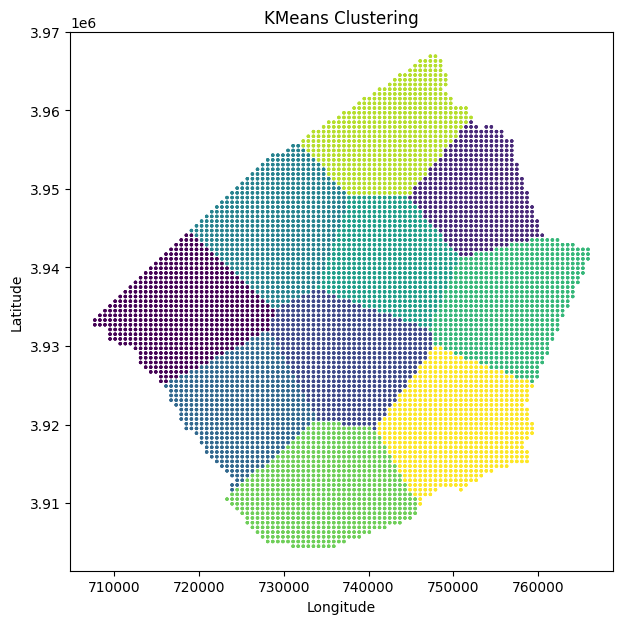

In [28]:
plt.figure(figsize=(7, 7))
plt.scatter(coords[:, 0], coords[:, 1], c=gdf_train_test['cluster'], cmap='viridis', s=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clustering')
plt.show()


In [34]:
# Get unique clusters
clusters = gdf_train_test['cluster'].unique()
np.random.shuffle(clusters)

# Split clusters into train, validation, and test sets
train_clusters = clusters[:7]    # Clusters 0 to 6 (70%)
val_clusters = clusters[7:8]     # Cluster 7 (10%)
test_clusters = clusters[8:]     # Clusters 8 and 9 (20%)

# Filter the original DataFrame to create the train, validation, and test DataFrames
train_gdf = gdf_train_test[gdf_train_test['cluster'].isin(train_clusters)].reset_index(drop=True)
val_gdf = gdf_train_test[gdf_train_test['cluster'].isin(val_clusters)].reset_index(drop=True)
test_gdf = gdf_train_test[gdf_train_test['cluster'].isin(test_clusters)].reset_index(drop=True)


# Create a mapping from clusters to sets
cluster_to_set = {}
for cluster in train_clusters:
    cluster_to_set[cluster] = 'Train'
for cluster in val_clusters:
    cluster_to_set[cluster] = 'Validation'
for cluster in test_clusters:
    cluster_to_set[cluster] = 'Test'

# Map the 'cluster' column to 'set' labels
gdf_train_test['set'] = gdf_train_test['cluster'].map(cluster_to_set)


# Display the number of samples in each split
print(f"Number of samples in the training set: {len(train_gdf)}")
print(f"Number of samples in the validation set: {len(val_gdf)}")
print(f"Number of samples in the test set: {len(test_gdf)}")

Number of samples in the training set: 12876
Number of samples in the validation set: 2007
Number of samples in the test set: 2979


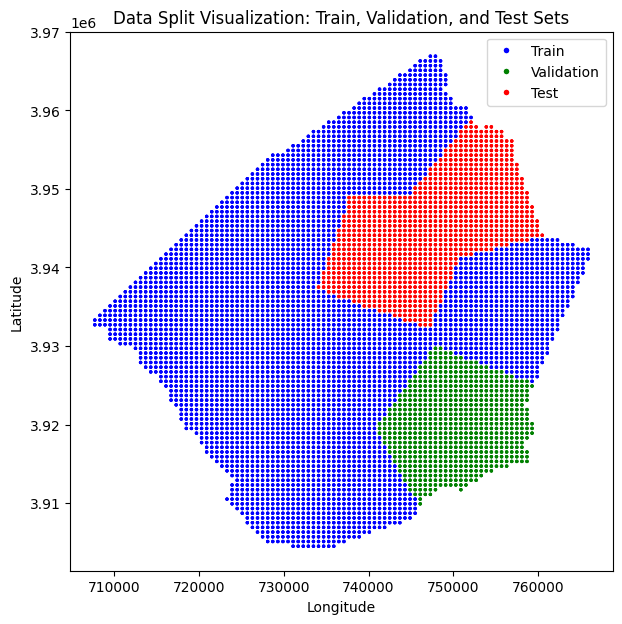

In [ ]:
# Plot the data points colored by 'set'
plt.figure(figsize=(7, 7))

# Define colors for each set
colors = {'Train': 'blue', 'Validation': 'green', 'Test': 'red'}

# Map 'set' labels to colors
point_colors = gdf_train_test['set'].map(colors)

# Plot
plt.scatter(coords[:, 0], coords[:, 1], c=point_colors, s=2)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train', markerfacecolor='blue', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Validation', markerfacecolor='green', markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Test', markerfacecolor='red', markersize=5)
]

plt.legend(handles=legend_elements, loc='best')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Data Split Visualization: Train, Validation, and Test Sets')
plt.show()